In [85]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import joblib

In [40]:
# Import data from csv
df = pd.read_csv('../datasets/cleaned/combined_stemmed_text_with_category_label.csv')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271009 entries, 0 to 1271008
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1271009 non-null  object
 1   category   1271009 non-null  object
 2   label      1271009 non-null  int64 
 3   stem_text  1270958 non-null  object
 4   lemm_text  1270958 non-null  object
dtypes: int64(1), object(4)
memory usage: 48.5+ MB


In [36]:
df.tail(1)

,label,stem_text,lemm_text
1271008,20,need kinect play game game requir kinect game ...,need kinect play game game require kinect game...


In [27]:
## only using original text and label for tuning
df.drop(columns=['category', 'text'], inplace=True)

In [28]:
df.head(1)

,label,stem_text,lemm_text
0,0,year old badger need replac badger instal like...,year old badger need replacing badger install ...


In [29]:
SAMPLE_RATIO = .01
sample_df = pd.DataFrame(columns=['text','label'])

for i in range(len(df['label'].unique())):
    sample = df.groupby('label').get_group(i).sample(frac=SAMPLE_RATIO, random_state=42)
    sample_df = sample_df.append(sample)
    
print(f"sample size: {sample_df.shape[0]}")

sample size: 12710


In [30]:
sample_df['label'].value_counts(sort=False, normalize=True) * 100

0      0.700236
1      1.636507
2      6.907946
3      2.006294
4      2.848151
5      6.168371
6      0.660897
7     23.422502
8      1.463415
9      5.759245
10    13.446105
11     0.912667
12     1.801731
13     3.343824
14     4.594807
15     2.643588
16     0.637293
17     8.583792
18     7.765539
19     3.981117
20     0.715972
Name: label, dtype: float64

In [47]:
sample_df['label'] = sample_df['label'].astype(int)

In [48]:
sample_df.dtypes

text         object
label         int32
stem_text    object
lemm_text    object
dtype: object

## Tuning with RandomizedSearchCV

In [49]:
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf',RandomForestClassifier()),
])

param_grid = {
    'vec__ngram_range': [(1,1), (1,2)],
    'vec__min_df': [1, 5, 10],
    'vec__max_df': [.9, .95, 1],
#     'vec__use_idf': [True, False],
#     'clf__bootstrap': [True, False],
    'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__min_samples_leaf': list(range(1,5)),
    'clf__min_samples_split': list(range(2,11)),
    'clf__n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

model = RandomizedSearchCV(
    pipe, 
    param_grid, 
    n_iter = 50, 
    cv = 3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)

### Stemmed text

In [50]:
%%time
X_sample = sample_df['stem_text']
y_sample = sample_df['label']
model.fit(X_sample, y_sample)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


Wall time: 3min 7s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           None],
                                        'clf__max_features': ['auto', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 2, 3, 4],
                                        'clf__min_samples_split': [2, 3, 4, 5,
                                                                   6, 7, 8, 9,
                                                                   10],
                                        'clf__n_estimators': [100, 200, 400,
                                           

In [51]:
model.best_params_

{'vec__ngram_range': (1, 1),
 'vec__min_df': 1,
 'vec__max_df': 0.95,
 'clf__n_estimators': 1200,
 'clf__min_samples_split': 9,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'auto',
 'clf__max_depth': None}

In [52]:
# score sample model on itself (sample set)
model.score(X_sample, y_sample)

0.6871754523996852

### Lemmatized text

In [53]:
%%time
X_sample = sample_df['lemm_text']
y_sample = sample_df['label']
model.fit(X_sample, y_sample)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


Wall time: 3min 6s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           None],
                                        'clf__max_features': ['auto', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 2, 3, 4],
                                        'clf__min_samples_split': [2, 3, 4, 5,
                                                                   6, 7, 8, 9,
                                                                   10],
                                        'clf__n_estimators': [100, 200, 400,
                                           

In [55]:
model.best_params_

{'vec__ngram_range': (1, 1),
 'vec__min_df': 1,
 'vec__max_df': 0.95,
 'clf__n_estimators': 1200,
 'clf__min_samples_split': 9,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'auto',
 'clf__max_depth': None}

In [54]:
# score sample model on itself (sample set)
model.score(X_sample, y_sample)

0.6870967741935484

## Evaluating Model

In [75]:
vec = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=1,
    max_df=.95,
    lowercase=False,
)
X = df['lemm_text'].apply(lambda x: np.str_(x))
X = vec.fit_transform(X)

In [76]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.1,
    random_state=42,
    shuffle=True,
    stratify=y
)

In [77]:
eval_model = RandomForestClassifier(
    n_estimators=1200,
    min_samples_split= 9,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=None,
    n_jobs=-1,
)

In [78]:
%%time

eval_model.fit(X_train, y_train)

Wall time: 3h 28min 19s


RandomForestClassifier(min_samples_leaf=2, min_samples_split=9,
                       n_estimators=1200, n_jobs=-1)

In [81]:
%%time
# score train model on itself (train set)
eval_model.score(X_train, y_train)

Wall time: 3min 4s


0.6299964682474465

In [82]:
%%time
# score sample sized model on test set
eval_model.score(X_test, y_test)

Wall time: 19.9 s


0.5719073807444474

In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [115]:
category_list = [
    'appliances',
    'arts_crafts_and_sewing',
    'automotive',
    'baby',
    'beauty',
    'cell_phones_and_accessories',
    'clothing_shoes_and_jewelry',
    'electronics',
    'grocery_and_gourmet_food',
    'health_and_personal_care',
    'home_and_kitchen',
    'industrial_and_scientific',
    'musical_instruments',
    'office_products',
    'patio_lawn_and_garden',
    'pet_supplies',
    'software',
    'sports_and_outdoors',
    'tools_and_home_improvement',
    'toys_and_games',
    'video_games',
]

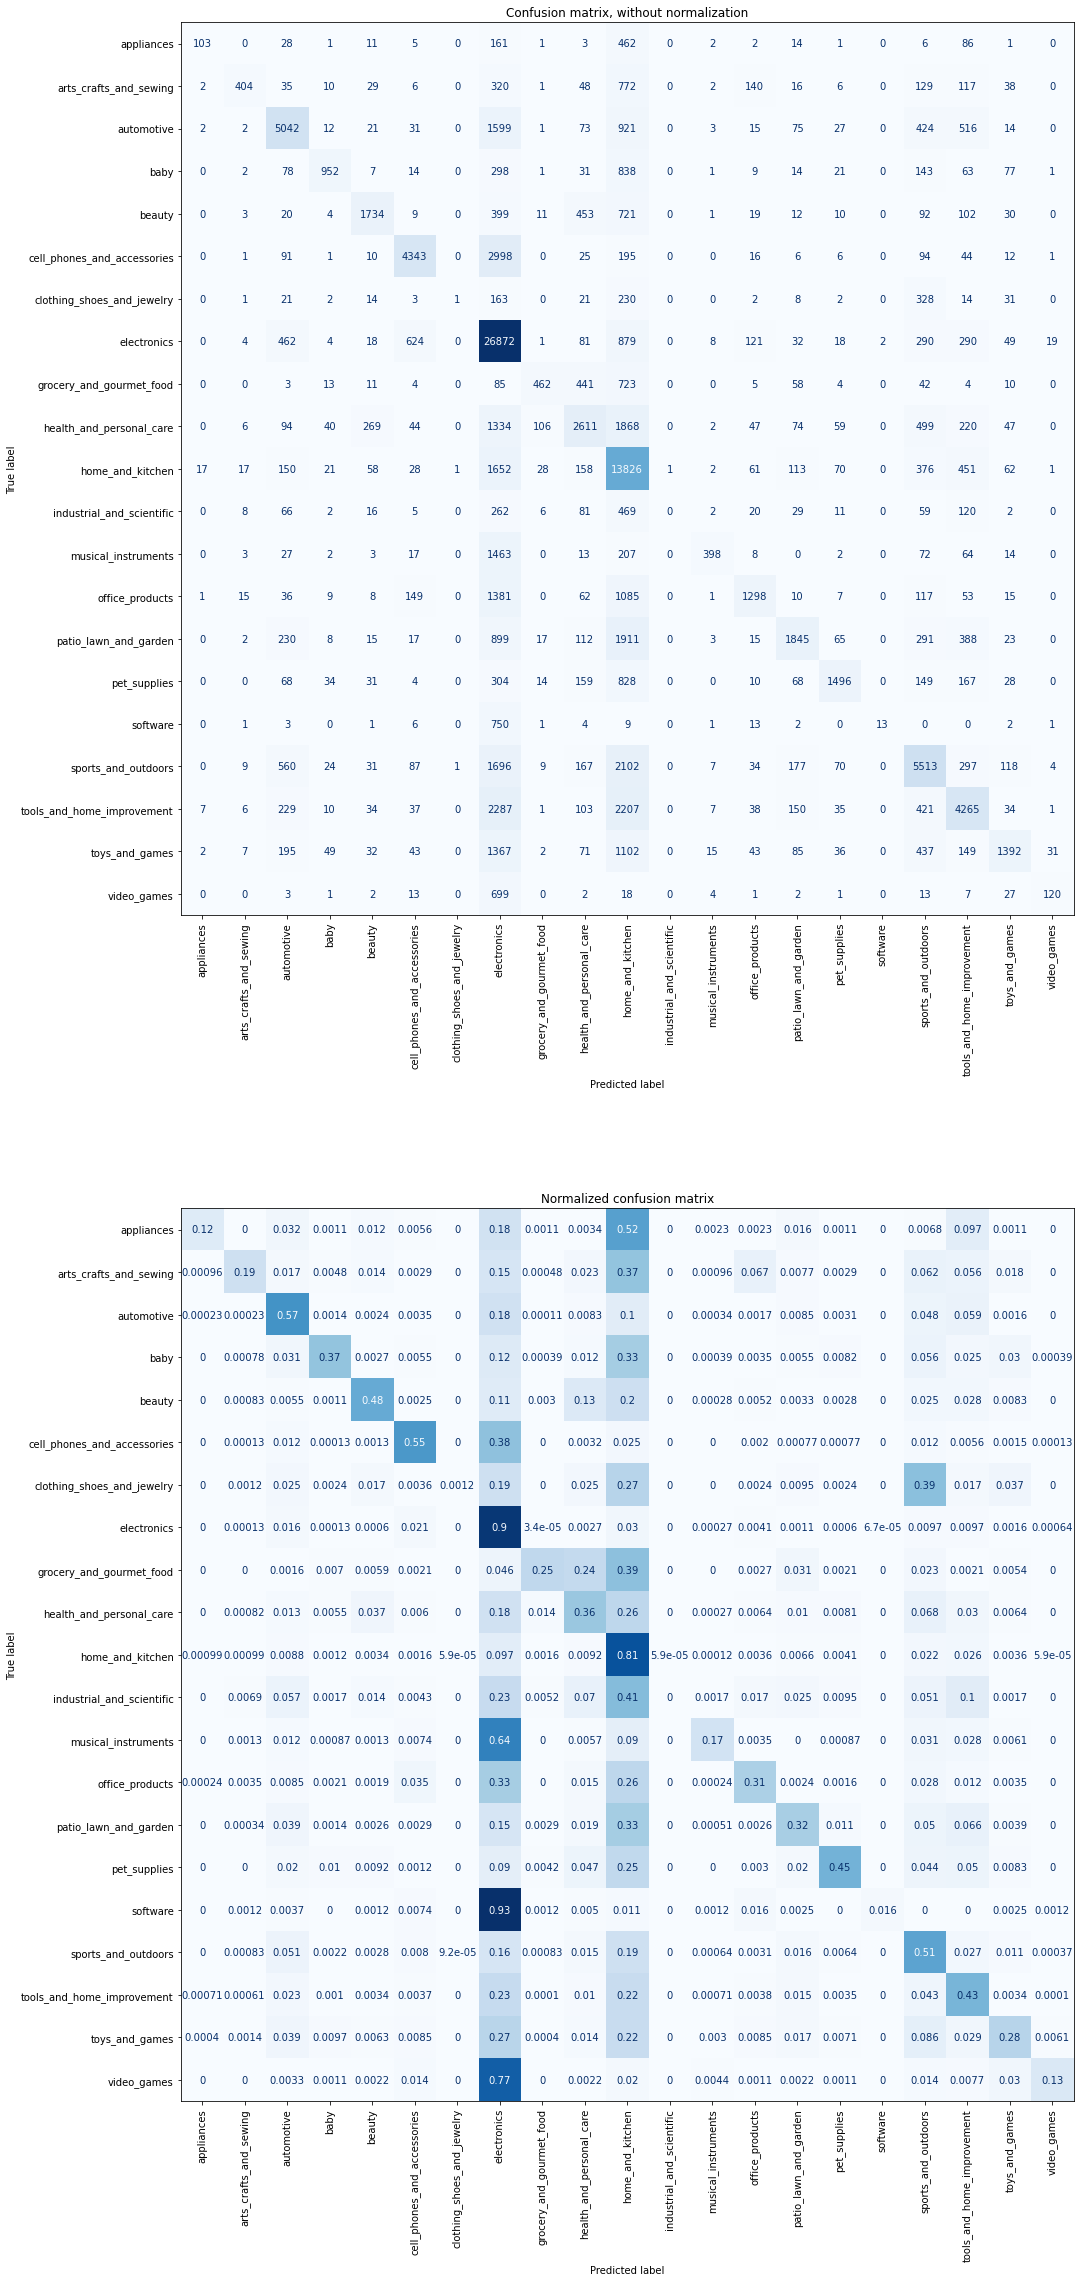

In [120]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax = plt.subplots(2, 1, figsize=(20, 40))
i = 0
for title, normalize in titles_options:
    ax[i] = plot_confusion_matrix(
        eval_model, X_test, y_test,
        display_labels=category_list,
        cmap=plt.cm.Blues,
        normalize=normalize,
        xticks_rotation='vertical',
        ax=ax[i])
    ax[i].ax_.set_title(title)
    ax[i].ax_.images[0].colorbar.remove()
    i+=1
plt.show()

In [97]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import regex as regex

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mriva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mriva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
def get_stopwords(file='../datasets/stopwords/stopwords.txt'):
    '''
    Description: Retreives stopwords from text file
    ---
    params:

    file:str       - file path
    ---
    output:
    
    set {str} of stopwords:
    {'a', 'set', 'of', 'words', ...}
    ---
    usage:
    >> list(get_stopwords())
    ['a', 'set', 'of', 'words', ...]
    '''
    with open(file,'r') as words:
        stopwords = [word.strip() for word in words]
        return set(stopwords)

In [99]:
def preprocess_text(txt, analyzer = 'stem'):
    '''
    Description: Tokenizes alphabets only. then Choose either to stem or lemmatize.
    ---
    params:

    txt:str       - text to process

    analyzer:str  - 'stem' = PorterStemmer (default)
                  - 'lemm' = WordNetLemmatizer
    ---
    output:
    
    processed text: str 
    ---
    usage:
    >> text = 'I have a 9 year old Badger 1 that needs'
    >> preprocess_text(text, analyzer='stem'))
    'year old badger need'
    # or however the the stemmed output should look like
    '''
    tokenizer = RegexpTokenizer(r'[A-Za-z]+', gaps=False)
    tokens = tokenizer.tokenize(str(txt).lower())
    
    #remove stop words
    all_stopwords = stopwords.words('english')
    all_stopwords.extend(list(get_stopwords()))
    tokens = [w for w in tokens if w not in all_stopwords]
    
    # analyze using lemmatizer
    if analyzer == 'lemm':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(s) for s in tokens]
        
    # analyze using stem
    elif analyzer == 'stem':
        p_stemmer = PorterStemmer()
        tokens = [p_stemmer.stem(s) for s in tokens]
    
    
    text = " ".join(tokens)
    return(text)

In [112]:
# testing new entry

question = "How do I change the volume of the speaker?"
question = preprocess_text(question, analyzer='lemm')
question_vec = vec.transform([question])
question_proba = eval_model.predict_proba(question_vec)
pd.DataFrame({
    'category':category_list,
    'probability':question_proba[0],
}).sort_values(by='probability', ascending=False)

,category,probability
7,electronics,0.691287
5,cell_phones_and_accessories,0.085000
12,musical_instruments,0.073217
10,home_and_kitchen,0.026941
13,office_products,0.022351
18,tools_and_home_improvement,0.014559
9,health_and_personal_care,0.014240
17,sports_and_outdoors,0.012558
19,toys_and_games,0.011385
2,automotive,0.011125


In [86]:
# Export Model
filename = f"../models/MulticlassCategoryLabel_NoSMOTE_RandomForestClassifier_EvaluationModel.sav"
joblib.dump(eval_model, filename)

['../models/MulticlassCategoryLabel_NoSMOTE_RandomForestClassifier_EvaluationModel.sav']

exported model is 13BG+ which is too big for 